In [2]:
!pip install transformers[torch]
!pip install accelerate>=0.21.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [4]:
import transformers

print(transformers.__version__)


4.41.2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
import pandas as pd
data=pd.read_csv(r"/content/drive/MyDrive/CallCenterAudioTranscriptions.csv")

In [9]:
data.drop(columns=['Reason'], inplace=True)


In [10]:
data.head()

,Text,Tag
0,“Thank you for calling Blend and Suns. If this...,Missed Call
1,“Thank you for calling Blind and Sons. If this...,Missed Call
2,“Thank you for calling Blend and Sons. If this...,New Customer - Lead Not Booked
3,“Thank you for calling Blend and Sons. If this...,Other
4,“Thank you for calling Blend and Sons. If this...,Other


In [11]:
import pandas as pd
data = data.dropna().drop_duplicates()

In [12]:
data.shape


(908, 2)

In [13]:
labels = data['Tag'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Missed Call',
 'New Customer -  Lead Not Booked',
 'Other',
 'Existing Customer -  Lead Not Booked',
 'Voicemail - Lead',
 'New Customer - Lead Booked',
 'Out of Service Capabilities',
 'Existing Customer - Lead Booked']

In [14]:
for key, value in enumerate(labels):
    print(value)

Missed Call
New Customer -  Lead Not Booked
Other
Existing Customer -  Lead Not Booked
Voicemail - Lead
New Customer - Lead Booked
Out of Service Capabilities
Existing Customer - Lead Booked


In [15]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [16]:
label2id

{'Missed Call': 0,
 'New Customer -  Lead Not Booked': 1,
 'Other': 2,
 'Existing Customer -  Lead Not Booked': 3,
 'Voicemail - Lead': 4,
 'New Customer - Lead Booked': 5,
 'Out of Service Capabilities': 6,
 'Existing Customer - Lead Booked': 7}

In [17]:
id2label


{0: 'Missed Call',
 1: 'New Customer -  Lead Not Booked',
 2: 'Other',
 3: 'Existing Customer -  Lead Not Booked',
 4: 'Voicemail - Lead',
 5: 'New Customer - Lead Booked',
 6: 'Out of Service Capabilities',
 7: 'Existing Customer - Lead Booked'}

In [18]:
data.head()

,Text,Tag
0,“Thank you for calling Blend and Suns. If this...,Missed Call
1,“Thank you for calling Blind and Sons. If this...,Missed Call
2,“Thank you for calling Blend and Sons. If this...,New Customer - Lead Not Booked
3,“Thank you for calling Blend and Sons. If this...,Other
4,“Thank you for calling Blend and Sons. If this...,Other


In [19]:
data["labels"]=data.Tag.map(lambda x: label2id[x.strip()])


In [20]:
data.head()

,Text,Tag,labels
0,“Thank you for calling Blend and Suns. If this...,Missed Call,0
1,“Thank you for calling Blind and Sons. If this...,Missed Call,0
2,“Thank you for calling Blend and Sons. If this...,New Customer - Lead Not Booked,1
3,“Thank you for calling Blend and Sons. If this...,Other,2
4,“Thank you for calling Blend and Sons. If this...,Other,2


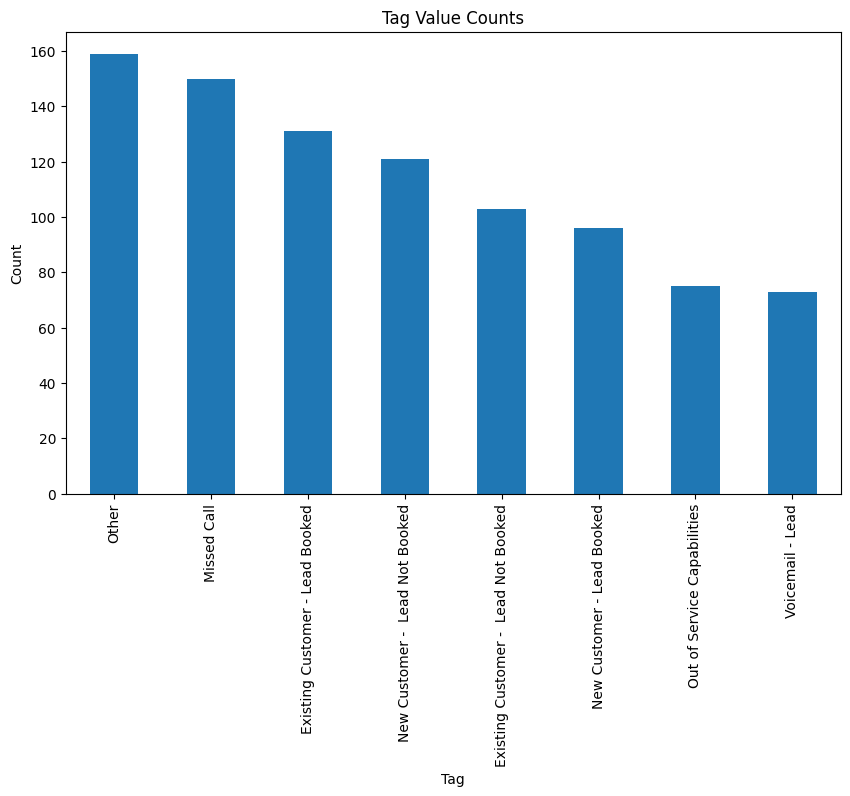

In [21]:
import matplotlib.pyplot as plt

data.Tag.value_counts().plot(kind='bar', figsize=(10,6))
plt.title('Tag Value Counts')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()


In [22]:
tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased", max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Data Splitting

In [24]:
SIZE= data.shape[0]

train_texts= list(data.Text[:SIZE//2])

val_texts=   list(data.Text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(data.Text[(3*SIZE)//4:])

train_labels= list(data.labels[:SIZE//2])

val_labels=   list(data.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(data.labels[(3*SIZE)//4:])

In [25]:
len(train_texts)


454

In [26]:
len(train_texts), len(val_texts), len(test_texts)


(454, 227, 227)

In [27]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)


In [28]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [29]:

train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

Training with Trainer Class


In [30]:
from transformers import TrainingArguments, Trainer


In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [79]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./results',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [80]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [81]:
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.016500,5.140557,0.383260,0.341625,0.343651,0.393536
100,0.033700,5.310059,0.374449,0.338062,0.352256,0.372083
150,0.083000,5.501994,0.383260,0.346404,0.353762,0.386950
200,0.073500,5.199419,0.422907,0.378039,0.400006,0.474407
250,0.017200,5.033704,0.409692,0.353171,0.361770,0.409160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

TrainOutput(global_step=290, training_loss=0.039183325962773685, metrics={'train_runtime': 127.0056, 'train_samples_per_second': 35.746, 'train_steps_per_second': 2.283, 'total_flos': 1194588542238720.0, 'train_loss': 0.039183325962773685, 'epoch': 10.0})

In [82]:
q=[trainer.evaluate(eval_dataset=data) for data in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.007577,0.995595,0.997361,0.997685,0.997093
val,5.085801,0.405286,0.351434,0.362738,0.400090
test,4.027188,0.546256,0.489669,0.463210,0.582359


In [83]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text
    tokens = tokenizer(text, padding=True, truncation=False, return_tensors="pt")
    input_ids = tokens['input_ids'][0]
    attention_mask = tokens['attention_mask'][0]

    # Split the input into chunks of up to 512 tokens
    max_length = 512
    num_chunks = (len(input_ids) + max_length - 1) // max_length  # Compute number of chunks
    chunk_probs = []

    for i in range(num_chunks):
        start_idx = i * max_length
        end_idx = min((i + 1) * max_length, len(input_ids))
        input_ids_chunk = input_ids[start_idx:end_idx].unsqueeze(0).to("cuda")
        attention_mask_chunk = attention_mask[start_idx:end_idx].unsqueeze(0).to("cuda")

        # Get model output (logits) for the chunk
        with torch.no_grad():
            outputs = model(input_ids=input_ids_chunk, attention_mask=attention_mask_chunk)

        # Calculate class probabilities for the chunk
        probs_chunk = outputs[0].softmax(1)
        chunk_probs.append(probs_chunk)

    # Aggregate probabilities across chunks
    probs = torch.mean(torch.stack(chunk_probs), dim=0)

    # Get the index of the class with the highest probability
    pred_label_idx = probs.argmax()

    # Map the predicted class index to the actual class label
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [84]:

# Test with a an example text in Turkish
t = data['Text'][4]
# "Machine Learning itself is moving towards more and more automated"
predict(t)

(tensor([[1.0584e-04, 1.8124e-06, 9.9986e-01, 9.0970e-06, 1.0471e-05, 2.2777e-06,
          2.8963e-06, 6.5909e-06]], device='cuda:0'),
 tensor(2, device='cuda:0'),
 'Other')

Save model for inference


In [85]:
model_path = "/content/drive/MyDrive/Call-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/Call-text-classification-model/tokenizer_config.json',
 '/content/drive/MyDrive/Call-text-classification-model/special_tokens_map.json',
 '/content/drive/MyDrive/Call-text-classification-model/vocab.txt',
 '/content/drive/MyDrive/Call-text-classification-model/added_tokens.json',
 '/content/drive/MyDrive/Call-text-classification-model/tokenizer.json')

Re-Load saved model for inference


In [86]:
model_path = "/content/drive/MyDrive/Call-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [87]:
nlp(data['Text'][67])


[{'label': 'Out of Service Capabilities', 'score': 0.9999942779541016}]

In [88]:
data['Tag'][67]

'Out of Service Capabilities'